Based on the EDA, performing the following actions

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import scipy.stats as stats
from sklearn.metrics import silhouette_score

In [2]:
import warnings
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
merged_df = pd.read_csv("merged_file.csv")

In [4]:
# Assuming 'merged_df' is your preprocessed DataFrame and you have already identified numeric_cols
numeric_cols = merged_df.select_dtypes(include=['float64', 'int64']).columns

# Define the percentile thresholds
lower_percentile = 0.02
upper_percentile = 0.98

# Capping the outliers for all numerical features in the DataFrame
for col in numeric_cols:
    # Compute the 1st and 99th percentiles
    lower_bound = merged_df[col].quantile(lower_percentile)
    upper_bound = merged_df[col].quantile(upper_percentile)
    
    # Cap values below the 1st percentile to the 1st percentile value
    # Cap values above the 99th percentile to the 99th percentile value
    merged_df[col] = np.where(merged_df[col] < lower_bound, lower_bound, merged_df[col])
    merged_df[col] = np.where(merged_df[col] > upper_bound, upper_bound, merged_df[col])


In [5]:
merged_df.head()

,Country,Crop_Name,Year,Area harvested_ha,Production_t,Yield_100 g/ha,Export Quantity_t,Export Value_1000 USD,Import Quantity_t,Import Value_1000 USD,...,Area_to_Production_ratio,Area_Value_to_Pesticide_ratio,Pesticide_to_Production_ratio,Export_to_Production_ratio,Import_to_Production_ratio,Country_Production_Mean,Crop_Production_Median,Yearly_Pesticide_Sum,Country_Yield_Std,Crop_Emission_Total
0,Brazil,Maize (corn),2000.0,11890376.0,32321000.0,27182.0,6699.0,9366.0,1771194.0,201960.0,...,0.367884,5.922299,0.004367,0.000207,0.0548,3.514974e+07,106178315.0,3.271649e+08,13073.599468,764660.6388
1,Brazil,Maize (corn),2000.0,11890376.0,32321000.0,27182.0,6699.0,9366.0,1771194.0,201960.0,...,0.367884,5.922299,0.004367,0.000207,0.0548,3.514974e+07,106178315.0,3.271649e+08,13073.599468,764660.6388
2,Brazil,Maize (corn),2000.0,11890376.0,32321000.0,27182.0,6699.0,9366.0,1771194.0,201960.0,...,0.367884,5.922299,0.004367,0.000207,0.0548,3.514974e+07,106178315.0,3.271649e+08,13073.599468,764660.6388
3,Brazil,Maize (corn),2000.0,11890376.0,32321000.0,27182.0,6699.0,9366.0,1771194.0,201960.0,...,0.367884,5.922299,0.004367,0.000207,0.0548,3.514974e+07,106178315.0,3.271649e+08,13073.599468,764660.6388
4,Brazil,Maize (corn),2000.0,11890376.0,32321000.0,27182.0,6699.0,9366.0,1771194.0,201960.0,...,0.367884,5.922299,0.004367,0.000207,0.0548,3.514974e+07,106178315.0,3.271649e+08,13073.599468,764660.6388


In [6]:
# List of relevant features
relevant_features = [
    'Country', 'Crop_Name', 'Year', 'Area harvested_ha', 'Production_t', 'Yield_100 g/ha',
    'Export Quantity_t', 'Export Value_1000 USD', 'Import Quantity_t', 'Import Value_1000 USD',
    'Emission_type', 'Emission_Value_kt', 'Gross_Production_Value_1000 USD', 'Area_Value_1000 ha',
    'Pesticide_Type', 'Pesticide_Value_t', 'Fertilizer_Usage_Value_kg/ha',
    'Emission_to_Production_ratio', 'Emission_to_Area_ratio', 'Emission_Value_per_Pesticide',
    'Area_to_Production_ratio'
]

In [7]:
# Create a new DataFrame with only the selected features
data_relevant = merged_df[relevant_features]

data_relevant.head()

,Country,Crop_Name,Year,Area harvested_ha,Production_t,Yield_100 g/ha,Export Quantity_t,Export Value_1000 USD,Import Quantity_t,Import Value_1000 USD,...,Emission_Value_kt,Gross_Production_Value_1000 USD,Area_Value_1000 ha,Pesticide_Type,Pesticide_Value_t,Fertilizer_Usage_Value_kg/ha,Emission_to_Production_ratio,Emission_to_Area_ratio,Emission_Value_per_Pesticide,Area_to_Production_ratio
0,Brazil,Maize (corn),2000.0,11890376.0,32321000.0,27182.0,6699.0,9366.0,1771194.0,201960.0,...,6.4353,3568843.0,835814.0,Pesticides (total),141130.0,30.0631,1.991058e-07,5.412192e-07,0.000046,0.367884
1,Brazil,Maize (corn),2000.0,11890376.0,32321000.0,27182.0,6699.0,9366.0,1771194.0,201960.0,...,6.4353,3568843.0,835814.0,Pesticides (total),141130.0,19.3971,1.991058e-07,5.412192e-07,0.000046,0.367884
2,Brazil,Maize (corn),2000.0,11890376.0,32321000.0,27182.0,6699.0,9366.0,1771194.0,201960.0,...,6.4353,3568843.0,835814.0,Pesticides (total),141130.0,40.2513,1.991058e-07,5.412192e-07,0.000046,0.367884
3,Brazil,Maize (corn),2000.0,11890376.0,32321000.0,27182.0,6699.0,9366.0,1771194.0,201960.0,...,6.4353,3568843.0,835814.0,Pesticides (total),141130.0,21.9175,1.991058e-07,5.412192e-07,0.000046,0.367884
4,Brazil,Maize (corn),2000.0,11890376.0,32321000.0,27182.0,6699.0,9366.0,1771194.0,201960.0,...,6.4353,3568843.0,835814.0,Pesticides (total),141130.0,5.3077,1.991058e-07,5.412192e-07,0.000046,0.367884


In [8]:
# Select only numerical features for the correlation matrix
numerical_features = data_relevant.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = data_relevant[numerical_features].corr()

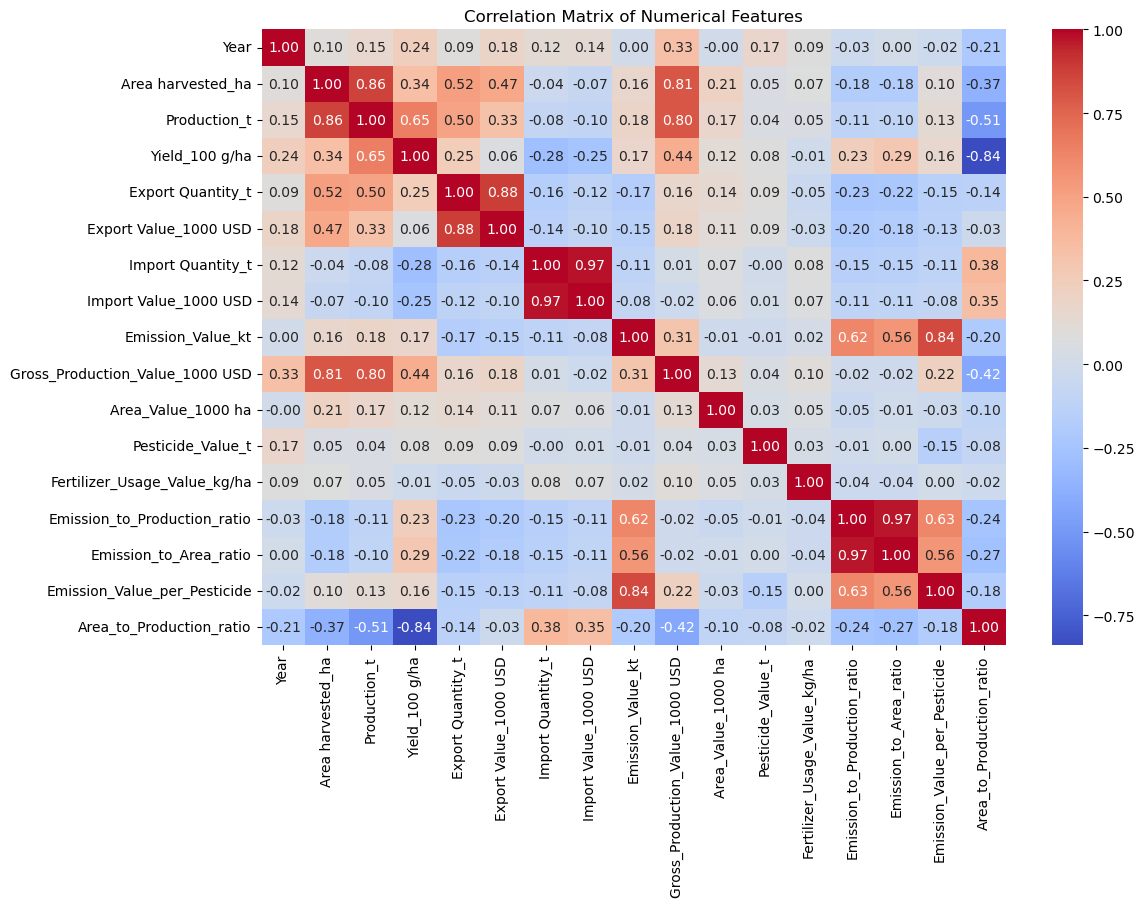

In [9]:
# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [10]:
# Dropping highly correlated features based on heatmap analysis
columns_to_drop = ['Area harvested_ha', 'Export Quantity_t', 'Import Value_1000 USD', 'Gross_Production_Value_1000 USD']
data_reduced = data_relevant.drop(columns=columns_to_drop)

In [11]:
# Function to calculate VIF for each feature
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data['feature'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

In [12]:
#recalculate the VIF for the reduced dataset
vif_scores_reduced = calculate_vif(data_reduced.select_dtypes(include=['float64', 'int64', 'uint8']))
print(vif_scores_reduced.sort_values('VIF', ascending=False))

                         feature        VIF
0                           Year  61.411456
2                 Yield_100 g/ha  33.280659
9   Emission_to_Production_ratio  25.009138
10        Emission_to_Area_ratio  23.077749
12      Area_to_Production_ratio  15.948772
1                   Production_t   5.979949
5              Emission_Value_kt   4.641001
11  Emission_Value_per_Pesticide   4.369611
7              Pesticide_Value_t   2.442396
6             Area_Value_1000 ha   2.412640
3          Export Value_1000 USD   1.705579
8   Fertilizer_Usage_Value_kg/ha   1.500561
4              Import Quantity_t   1.486173


In [13]:
# Dropping the specified high VIF features
columns_to_drop_more = ['Yield_100 g/ha', 'Emission_to_Production_ratio', 'Emission_to_Area_ratio']
data_reduced_further = data_reduced.drop(columns=columns_to_drop_more)

In [14]:
data_reduced_further.head()

,Country,Crop_Name,Year,Production_t,Export Value_1000 USD,Import Quantity_t,Emission_type,Emission_Value_kt,Area_Value_1000 ha,Pesticide_Type,Pesticide_Value_t,Fertilizer_Usage_Value_kg/ha,Emission_Value_per_Pesticide,Area_to_Production_ratio
0,Brazil,Maize (corn),2000.0,32321000.0,9366.0,1771194.0,Crops total (Emissions N2O),6.4353,835814.0,Pesticides (total),141130.0,30.0631,0.000046,0.367884
1,Brazil,Maize (corn),2000.0,32321000.0,9366.0,1771194.0,Crops total (Emissions N2O),6.4353,835814.0,Pesticides (total),141130.0,19.3971,0.000046,0.367884
2,Brazil,Maize (corn),2000.0,32321000.0,9366.0,1771194.0,Crops total (Emissions N2O),6.4353,835814.0,Pesticides (total),141130.0,40.2513,0.000046,0.367884
3,Brazil,Maize (corn),2000.0,32321000.0,9366.0,1771194.0,Crops total (Emissions N2O),6.4353,835814.0,Pesticides (total),141130.0,21.9175,0.000046,0.367884
4,Brazil,Maize (corn),2000.0,32321000.0,9366.0,1771194.0,Crops total (Emissions N2O),6.4353,835814.0,Pesticides (total),141130.0,5.3077,0.000046,0.367884


In [15]:
vif_scores_updated = calculate_vif(data_reduced_further.select_dtypes(include=['float64', 'int64', 'uint8']))
print(vif_scores_updated.sort_values('VIF', ascending=False))

                        feature        VIF
0                          Year  12.977586
9      Area_to_Production_ratio   7.061414
4             Emission_Value_kt   4.137203
8  Emission_Value_per_Pesticide   4.079572
1                  Production_t   3.187067
6             Pesticide_Value_t   2.434507
5            Area_Value_1000 ha   2.369215
2         Export Value_1000 USD   1.642956
7  Fertilizer_Usage_Value_kg/ha   1.484445
3             Import Quantity_t   1.479326


In [16]:
# Define target variables
target_vars = ['Production_t']

In [17]:
# Define numerical and categorical columns, excluding the target columns
numerical_cols = data_reduced_further.select_dtypes(include=['int64', 'float64']).columns.difference(target_vars).tolist()
categorical_cols = data_reduced_further.select_dtypes(include=['object']).columns.tolist()

In [18]:
# Create the preprocessing pipeline for numerical data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Standardize numerical features
])

In [19]:
# Create the preprocessing pipeline for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Encode categorical features
])

In [20]:
# Combine all elements into a large transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [21]:
# Split data into training and testing sets based on the year
train = data_reduced_further[data_reduced_further['Year'] <= 2019]
test = data_reduced_further[data_reduced_further['Year'] > 2019]

# Drop the 'Year' column if it's no longer needed for modeling
X_train = train.drop(['Production_t'], axis=1)
y_train = train['Production_t']

X_test = test.drop(['Production_t'], axis=1)
y_test = test['Production_t']


## Random Forest

In [22]:
def calculate_metrics(y_t, y_p):
    model_mae = mean_absolute_error(y_t, y_p)
    model_mae_percentage = (model_mae / np.mean(y_t)) * 100

    # Mean Squared Error (MSE)
    model_mse = mean_squared_error(y_t, y_p)
    model_mse_percentage = (model_mse / (np.mean(y_t) ** 2)) * 100

    # Root Mean Squared Error (RMSE)
    model_rmse = np.sqrt(model_mse)
    model_rmse_percentage = (model_rmse / np.mean(y_t)) * 100

    model_r2 = r2_score(y_t, y_p)

    return model_mae_percentage, model_mse_percentage, model_rmse_percentage, model_r2

In [23]:
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, max_depth=8))
])

In [24]:
# Training the pipeline on the training data for Production
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Area_Value_1000 ha',
                                                   'Area_to_Production_ratio',
                                                   'Emission_Value_kt',
                                                   'Emission_Value_per_Pesticide',
                                                   'Export Value_1000 USD',
                                                   'Fertilizer_Usage_Value_kg/ha',
                                                   'Import Quantity_t',
                                                   'Pesticide_Value_t',
                                                   'Year']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Country', 'Crop_Name',
                                                   'Emission_type',
                                                   'Pesticide_Type'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=8, random_state=42))])

In [25]:
# Predicting on the train data
y_pred_train = pipeline_rf.predict(X_train)

In [26]:
rf_mae_train, rf_mse_train, rf_rmse_train, rf_r2_train = calculate_metrics(y_train, y_pred_train)

In [27]:
print("Mean Absolute Error (MAE): {:.2f}%".format(rf_mae_train))

print("Mean Squared Error (MSE): {:.2f}%".format(rf_mse_train))

print("Root Mean Squared Error (RMSE): {:.2f}%".format(rf_rmse_train))

print("R2 Score:", rf_r2_train)

Mean Absolute Error (MAE): 1.45%
Mean Squared Error (MSE): 0.07%
Root Mean Squared Error (RMSE): 2.72%
R2 Score: 0.9993595385793764


In [28]:
y_pred_test = pipeline_rf.predict(X_test)

In [29]:
rf_mae_test, rf_mse_test, rf_rmse_test, rf_r2_test = calculate_metrics(y_test, y_pred_test)

In [30]:
print("Mean Absolute Error (MAE): {:.2f}%".format(rf_mae_test))

print("Mean Squared Error (MSE): {:.2f}%".format(rf_mse_test))

print("Root Mean Squared Error (RMSE): {:.2f}%".format(rf_rmse_test))

print("R2 Score:", rf_r2_test)

Mean Absolute Error (MAE): 13.97%
Mean Squared Error (MSE): 11.98%
Root Mean Squared Error (RMSE): 34.62%
R2 Score: 0.8909154861661961


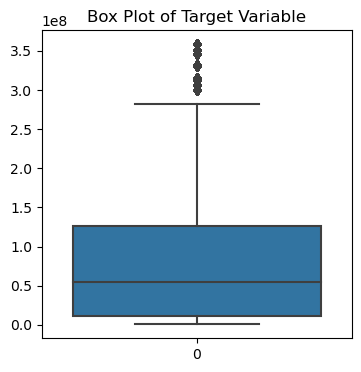

In [31]:
# Boxplot for target variable
plt.figure(figsize=(4, 4))
sns.boxplot(data_reduced_further['Production_t'])
plt.title('Box Plot of Target Variable')
plt.show()

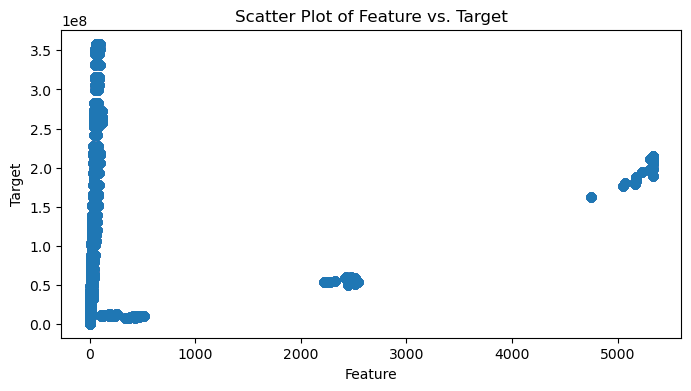

In [32]:
# Scatter plot for target variable against another feature that you suspect might be influencing outliers
plt.figure(figsize=(8, 4))
plt.scatter(data_reduced_further['Emission_Value_kt'], data_reduced_further['Production_t'])
plt.xlabel('Feature')
plt.ylabel('Target')
plt.title('Scatter Plot of Feature vs. Target')
plt.show()

In [33]:
# Calculate IQR for the target variable
Q1 = data_reduced_further['Production_t'].quantile(0.05)
Q3 = data_reduced_further['Production_t'].quantile(0.95)
IQR = Q3 - Q1

# Define thresholds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtering the data
filtered_df = data_reduced_further[(data_reduced_further['Production_t'] >= lower_bound) & (data_reduced_further['Production_t'] <= upper_bound)]

print(f"Original data points: {len(data_reduced_further)}")
print(f"Data points after outlier removal: {len(filtered_df)}")

Original data points: 59076
Data points after outlier removal: 59076


In [34]:
# Split data into training and testing sets based on the year
train_filter = filtered_df[filtered_df['Year'] <= 2019]
test_filter = filtered_df[filtered_df['Year'] > 2019]

# Drop the 'Year' column if it's no longer needed for modeling
X_train_filter = train_filter.drop(['Production_t'], axis=1)
y_train_filter = train_filter['Production_t']

X_test_filter = test_filter.drop(['Production_t'], axis=1)
y_test_filter = test_filter['Production_t']


In [35]:
y_pred_train_filter = pipeline_rf.predict(X_train_filter)

In [36]:
rf_mae_train_filter, rf_mse_train_filter, rf_rmse_train_filter, rf_r2_train_filter = calculate_metrics(y_train_filter, y_pred_train_filter)

In [37]:
print("Mean Absolute Error (MAE): {:.2f}%".format(rf_mae_train_filter))

print("Mean Squared Error (MSE): {:.2f}%".format(rf_mse_train_filter))

print("Root Mean Squared Error (RMSE): {:.2f}%".format(rf_rmse_train_filter))

print("R2 Score:", rf_r2_train_filter)

Mean Absolute Error (MAE): 1.45%
Mean Squared Error (MSE): 0.07%
Root Mean Squared Error (RMSE): 2.72%
R2 Score: 0.9993595385793764


In [38]:
y_pred_test_filter = pipeline_rf.predict(X_test_filter)

In [39]:
rf_mae_test_filter, rf_mse_test_filter, rf_rmse_test_filter, rf_r2_test_filter = calculate_metrics(y_test_filter, y_pred_test_filter)

In [40]:
print("Mean Absolute Error (MAE): {:.2f}%".format(rf_mae_test_filter))

print("Mean Squared Error (MSE): {:.2f}%".format(rf_mse_test_filter))

print("Root Mean Squared Error (RMSE): {:.2f}%".format(rf_rmse_test_filter))

print("R2 Score:", rf_r2_test_filter)

Mean Absolute Error (MAE): 13.97%
Mean Squared Error (MSE): 11.98%
Root Mean Squared Error (RMSE): 34.62%
R2 Score: 0.8909154861661961


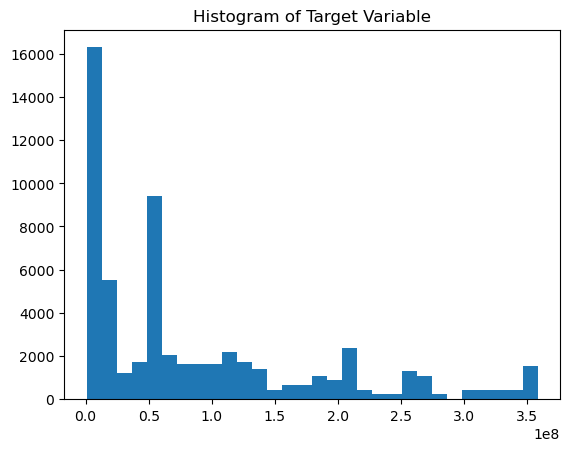

In [41]:
import matplotlib.pyplot as plt
plt.hist(filtered_df['Production_t'], bins=30)
plt.title('Histogram of Target Variable')
plt.show()

In [42]:
# Define thresholds
threshold = 1.5e8

In [82]:
# Create subsets
def divide_segments(threshold, segment_no):
    segment1 = filtered_df[filtered_df['Production_t'] <= threshold]
    segment2 = filtered_df[filtered_df['Production_t'] > threshold] #& (filtered_df['Production_t'] <= threshold2)]
# segment3 = filtered_df[(filtered_df['Production_t'] > threshold)
    if segment_no == 1:
        return segment1
    else:
        return segment2

In [85]:
X1 = divide_segments(threshold,1).drop('Production_t', axis=1)
y1 = divide_segments(threshold,1)['Production_t']
X2 = divide_segments(threshold,2).drop('Production_t', axis=1)
y2 = divide_segments(threshold,2)['Production_t']

In [72]:
# Pipeline for segment 1: Linear Regression
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

pipeline_lasso = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=1.0, random_state=42))
])

# pipeline for segment 2: Ridge Regressor
pipeline_ridge = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0, random_state=42))
])
# Pipeline for segment 2: Random Forest Regressor
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, max_depth= 6))
])

# Pipeline for segment 3: Gradient Boosting Regressor
pipeline_gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(n_estimators=100, random_state=42))
])

In [63]:
# Function to split data and train pipeline
def train_test_pipeline(X, y, pipeline, mode):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    pipeline.fit(X_train, y_train)
    y_pred_tr = pipeline.predict(X_train)
    y_pred = pipeline.predict(X_test)
    mae_tr, mse_tr, rmse_tr, r2_tr = calculate_metrics(y_train, y_pred_tr)
    mae, mse, rmse, r2 = calculate_metrics(y_test, y_pred)
    if mode == 'test':
        return mae, mse, rmse, r2 
    if mode == 'train':
        return mae_tr, mse_tr, rmse_tr, r2_tr

In [87]:
# Applying pipelines
mae1_tr, mse1_tr, rmse1_tr, r21_tr = train_test_pipeline(X1, y1, pipeline_gb, 'train')
mae2_tr, mse2_tr, rmse2_tr, r22_tr = train_test_pipeline(X2, y2, pipeline_ridge, 'train')
# mae3_tr, mse2_tr, rmse2_tr, r23_tr = train_test_pipeline(segment3.drop('Production_t', axis=1), segment3['Production_t'], pipeline_gb)

print(f"Segment 1 - MAE: {mae1_tr}, MSE: {mse1_tr}, RMSE: {rmse1_tr}, R2: {r21_tr}")
print(f"Segment 2 - MAE: {mae2_tr}, MSE: {mse2_tr}, RMSE: {rmse2_tr}, R2: {r22_tr}")
# print(f"Segment 3 - MAE: {mae2_tr}, MSE: {mse2_tr}, RMSE: {rmse2_tr}, R2: {r22_tr}")

Segment 1 - MAE: 3.152615780519003, MSE: 0.21402795453505205, RMSE: 4.6263155376071365, R2: 0.9972410274895698
Segment 2 - MAE: 4.6420973140002015, MSE: 0.35265520696065433, RMSE: 5.938477978073627, R2: 0.9475179402257282


In [88]:
# Applying pipelines
mae1, mse1, rmse1, r21 = train_test_pipeline(X1,y1, pipeline_gb, 'test')
mae2, mse2, rmse2, r22 = train_test_pipeline(X2, y2, pipeline_ridge, 'test')
# mae3, mse2, rmse2, r23 = train_test_pipeline(segment3.drop('Production_t', axis=1), segment3['Production_t'], pipeline_gb)

print(f"Segment 1 - MAE: {mae1}, MSE: {mse1}, RMSE: {rmse1}, R2: {r21}")
print(f"Segment 2 - MAE: {mae2}, MSE: {mse2}, RMSE: {rmse2}, R2: {r22}")
# print(f"Segment 3 - MAE: {mae2}, MSE: {mse2}, RMSE: {rmse2}, R2: {r22}")

Segment 1 - MAE: 3.1728508674954767, MSE: 0.21900044520196887, RMSE: 4.67974833940853, R2: 0.9972027834397955
Segment 2 - MAE: 4.689211988272649, MSE: 0.3565108724214056, RMSE: 5.97085314190029, R2: 0.9457217511054501


## Finding Threshold based on Clustering

In [79]:
from sklearn.cluster import DBSCAN

def find_density_based_threshold(data):
    values = data['Production_t'].values.reshape(-1, 1)
    clustering = DBSCAN(eps=0.5, min_samples=10).fit(values)
    labels = clustering.labels_
    # Find transition points between clusters
    unique_labels = np.unique(labels)
    core_samples = np.array([values[labels == label].mean() for label in unique_labels if label != -1])
    if len(core_samples) > 1:
        sorted_samples = np.sort(core_samples)
        # Threshold between the first two clusters
        threshold = np.mean(sorted_samples[:2])
        return threshold
    return None

In [80]:
thrshold_db = find_density_based_threshold(filtered_df)

In [81]:
thrshold_db

794172.5

In [89]:
X_db1 = divide_segments(thrshold_db,1).drop('Production_t', axis=1)
y_db1 = divide_segments(thrshold_db,1)['Production_t']
X_db2 = divide_segments(thrshold_db,2).drop('Production_t', axis=1)
y_db2 = divide_segments(thrshold_db,2)['Production_t']

In [95]:
# Applying pipelines
mae1_db_tr, mse1_db_tr, rmse1_db_tr, r21_db_tr = train_test_pipeline(X_db1, y_db1,pipeline_rf, 'train')
mae2_db_tr, mse2_db_tr, rmse2_db_tr, r22_db_tr = train_test_pipeline(X_db2, y_db2, pipeline_ridge, 'train')
# mae3_tr, mse2_tr, rmse2_tr, r23_tr = train_test_pipeline(segment3.drop('Production_t', axis=1), segment3['Production_t'], pipeline_gb)

print(f"Segment 1 - MAE: {mae1_db_tr}, MSE: {mse1_db_tr}, RMSE: {rmse1_db_tr}, R2: {r21_db_tr}")
print(f"Segment 2 - MAE: {mae2_db_tr}, MSE: {mse2_db_tr}, RMSE: {rmse2_db_tr}, R2: {r22_db_tr}")
# print(f"Segment 3 - MAE: {mae2_tr}, MSE: {mse2_tr}, RMSE: {rmse2_tr}, R2: {r22_tr}")

Segment 1 - MAE: 0.0, MSE: 0.0, RMSE: 0.0, R2: 1.0
Segment 2 - MAE: 46.47262869450418, MSE: 33.30325902649874, RMSE: 57.70897592792541, R2: 0.6988649635421071


In [91]:
# Applying pipelines
mae1_db, mse1_db, rmse1_db, r21_db = train_test_pipeline(X_db1, y_db1,pipeline_gb, 'test')
mae2_db, mse2_db, rmse2_db, r22_db = train_test_pipeline(X_db2, y_db2, pipeline_ridge, 'test')
# mae3_tr, mse2_tr, rmse2_tr, r23_tr = train_test_pipeline(segment3.drop('Production_t', axis=1), segment3['Production_t'], pipeline_gb)

print(f"Segment 1 - MAE: {mae1_db}, MSE: {mse1_db}, RMSE: {rmse1_db}, R2: {r21_db}")
print(f"Segment 2 - MAE: {mae2_db}, MSE: {mse2_db}, RMSE: {rmse2_db}, R2: {r22_db}")
# print(f"Segment 3 - MAE: {mae2_tr}, MSE: {mse2_tr}, RMSE: {rmse2_tr}, R2: {r22_tr}")

Segment 1 - MAE: 0.0, MSE: 0.0, RMSE: 0.0, R2: 1.0
Segment 2 - MAE: 46.80141519737123, MSE: 33.58185364577033, RMSE: 57.949852153193916, R2: 0.6990325563879374


## Change Point Detection

In [97]:
pip install ruptures


     -------------------------------------- 473.0/473.0 kB 5.0 MB/s eta 0:00:00


In [98]:
from ruptures import Pelt
import ruptures as rpt

In [99]:
def find_change_point_threshold(data):
    values = data['Production_t'].values
    algo = rpt.Pelt(model="l2").fit(values)
    result = algo.predict(pen=10)
    # Find the first significant change point as the threshold
    if result:
        threshold = values[result[0]]
        return threshold
    return None

In [100]:
thr_cpd = find_change_point_threshold(filtered_df)

In [113]:
thr_cpd

32321000.0

In [103]:
X_cpd1 = divide_segments(thr_cpd,1).drop('Production_t', axis=1)
y_cpd1 = divide_segments(thr_cpd,1)['Production_t']
X_cpd2 = divide_segments(thr_cpd,2).drop('Production_t', axis=1)
y_cpd2 = divide_segments(thr_cpd,2)['Production_t']

In [112]:
# Applying pipelines
mae1_cpd_tr, mse1_cpd_tr, rmse1_cpd_tr, r21_cpd_tr = train_test_pipeline(X_cpd1, y_cpd1,pipeline_rf, 'train')
mae2_cpd_tr, mse2_cpd_tr, rmse2_cpd_tr, r22_cpd_tr = train_test_pipeline(X_cpd2, y_cpd2, pipeline_rf, 'train')
# mae3_tr, mse2_tr, rmse2_tr, r23_tr = train_test_pipeline(segment3.drop('Production_t', axis=1), segment3['Production_t'], pipeline_gb)

print(f"Segment 1 - MAE: {mae1_cpd_tr}, MSE: {mse1_cpd_tr}, RMSE: {rmse1_cpd_tr}, R2: {r21_cpd_tr}")
print(f"Segment 2 - MAE: {mae2_cpd_tr}, MSE: {mse2_cpd_tr}, RMSE: {rmse2_cpd_tr}, R2: {r22_cpd_tr}")
# print(f"Segment 3 - MAE: {mae2_tr}, MSE: {mse2_tr}, RMSE: {rmse2_tr}, R2: {r22_tr}")

Segment 1 - MAE: 3.5344960831814767, MSE: 0.37869495697947697, RMSE: 6.153819602324047, R2: 0.9887223305789683
Segment 2 - MAE: 2.3045382274654735, MSE: 0.15314668649915847, RMSE: 3.913396050735965, R2: 0.9966830774121341


In [108]:
# Applying pipelines
mae1_cpd, mse1_cpd, rmse1_cpd, r21_cpd = train_test_pipeline(X_cpd1, y_cpd1,pipeline_rf, 'train')
mae2_cpd, mse2_cpd, rmse2_cpd, r22_cpd = train_test_pipeline(X_cpd2, y_cpd2, pipeline_ridge, 'train')
# mae3_tr, mse2_tr, rmse2_tr, r23_tr = train_test_pipeline(segment3.drop('Production_t', axis=1), segment3['Production_t'], pipeline_gb)

print(f"Segment 1 - MAE: {mae1_cpd}, MSE: {mse1_cpd}, RMSE: {rmse1_cpd}, R2: {r21_cpd}")
print(f"Segment 2 - MAE: {mae2_cpd}, MSE: {mse2_cpd}, RMSE: {rmse2_cpd}, R2: {r22_cpd}")
# print(f"Segment 3 - MAE: {mae2_tr}, MSE: {mse2_tr}, RMSE: {rmse2_tr}, R2: {r22_tr}")

Segment 1 - MAE: 3.5344960831814767, MSE: 0.37869495697947697, RMSE: 6.153819602324047, R2: 0.9887223305789683
Segment 2 - MAE: 17.164890299160405, MSE: 4.9778554397768096, RMSE: 22.31110808493565, R2: 0.892187277930968
